# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(25,10)})
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import holidays

# Import prepared DF

In [263]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_36.csv")
print(df_days.head())

         date  nb_cars  nb_cars_cxl  nb_bookings  nb_bookings_cxl  \
0  2021-06-01       12            1            5                1   
1  2021-06-02        8            2           13                0   
2  2021-06-03       12            0            7                0   
3  2021-06-04       11            0           38                3   
4  2021-06-05       42            3           13                2   

   hourly rate  WE package  1 week package  1 month package  other package  \
0            8           2               2                0              0   
1            6           0               2                0              0   
2            7           0               4                0              1   
3            6           0               5                0              0   
4            7          32               3                0              0   

   ...  12H à 15H  0H à 6H  18H à 24H  +24h  06:00 24:00  00:30 06:00  \
0  ...          0        1          0    12

# Prophet nb of cars

## Just the nb of cars as y

In [264]:
df_prophet_cars = df_days[['date', 'nb_cars']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars.head()


,ds,y
0,2021-06-01,12
1,2021-06-02,8
2,2021-06-03,12
3,2021-06-04,11
4,2021-06-05,42


In [265]:
# Define the split percentages
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 675
test_rows: 37
validation_rows: 38



In [266]:
model = Prophet()
model.fit(df_prophet_cars)

# Create future dates for the test and validation periods
future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)


12:54:28 - cmdstanpy - INFO - Chain [1] start processing
12:54:28 - cmdstanpy - INFO - Chain [1] done processing


In [267]:
# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

RMSE for the test set: 24.57857537780436


In [268]:
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

MAPE for the test set: 51.544660231807995


## Forecast nb of cars with french holidays (from holidays package)

In [269]:
df_prophet_cars = df_days.drop(['nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'], axis=1)
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_cars['holiday'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_cars[df_prophet_cars['holiday']]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_cars)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=365)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))





/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_83026/641127344.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df['holiday'] = 'Holiday'
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:54:29 - cmdstanpy - INFO - Chain [1] start processing
12:54:29 - cmdstanpy - INFO - Chain [1] done processing
/Users/anaisetienne/

In [270]:
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

RMSE for the test set: 14.327078531874669
MAPE for the test set: 23.5340332754047


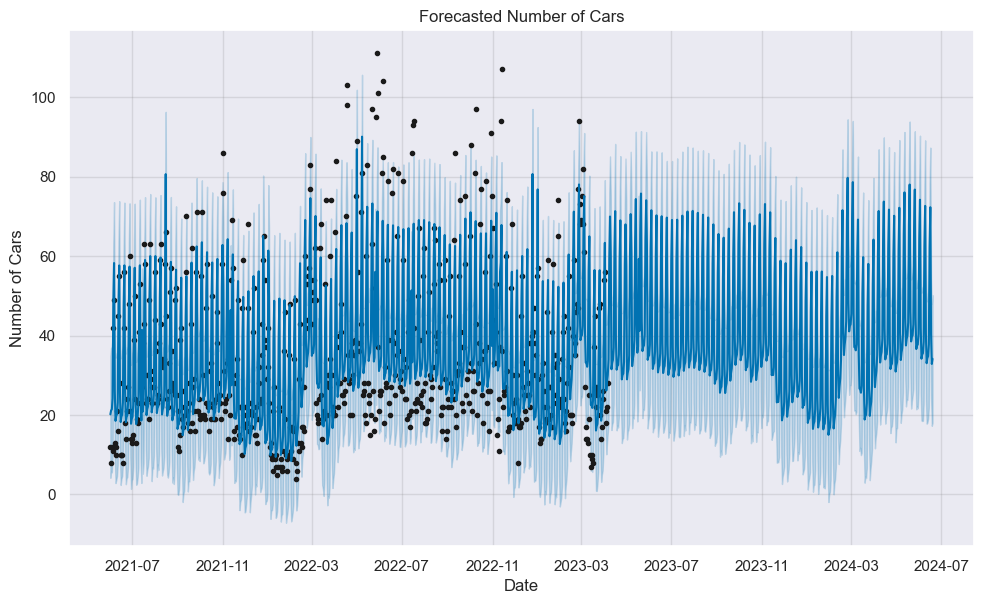

In [271]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

plt.show()

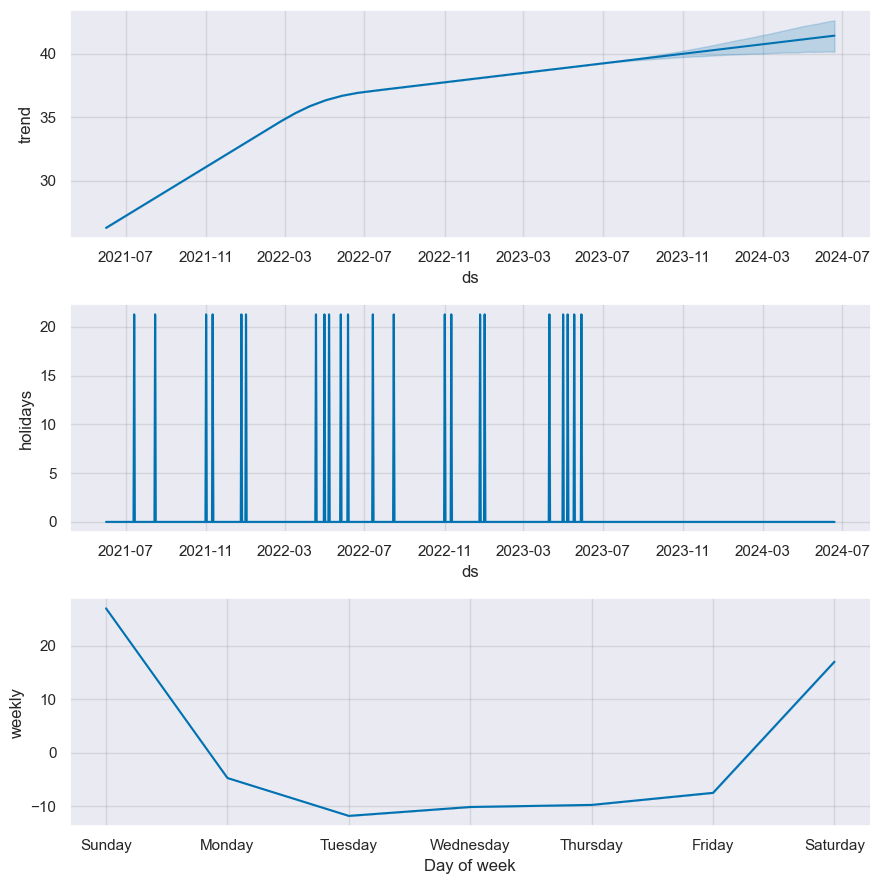

In [272]:
# Explain seasonality
fig2 = model.plot_components(forecast)


# Prophet nb of bookings

## Forecast nb of bookings 

In [273]:
df_prophet_bookings = df_days.drop(['nb_cars_cxl', 'nb_cars', 'nb_bookings_cxl'], axis=1)
df_prophet_bookings = df_prophet_bookings.rename(columns={'date': 'ds', 'nb_bookings': 'y'})
df_prophet_bookings.head()

,ds,y,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package,turnover,discount,...,12H à 15H,0H à 6H,18H à 24H,+24h,06:00 24:00,00:30 06:00,00:00 00:30,strike,holidays,vacation
0,2021-06-01,5,8,2,2,0,0,0,131.4,0.00,...,0,1,0,12,0,0,0,0,0,0
1,2021-06-02,13,6,0,2,0,0,0,424.7,0.00,...,1,0,0,8,0,0,0,0,0,0
2,2021-06-03,7,7,0,4,0,1,0,279.0,0.00,...,1,0,0,12,0,0,0,0,0,0
3,2021-06-04,38,6,0,5,0,0,0,1177.4,22.40,...,1,1,0,11,0,0,0,0,0,0
4,2021-06-05,13,7,32,3,0,0,0,317.6,3.92,...,11,1,5,42,0,0,0,0,0,0


In [274]:
# Define the split percentages
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_bookings[:train_rows]
test_set = df_prophet_bookings[train_rows:train_rows + test_rows]
validation_set = df_prophet_bookings[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 675
test_rows: 37
validation_rows: 38



In [275]:
model2 = Prophet()
model2.fit(train_set)

12:54:30 - cmdstanpy - INFO - Chain [1] start processing


12:54:30 - cmdstanpy - INFO - Chain [1] done processing


In [276]:
# Create future dates for the test and validation periods
future_test = model2.make_future_dataframe(periods=len(test_set))
future_validation = model2.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model2.predict(future_test)
forecast_validation = model2.predict(future_validation)

In [277]:
# Calculate RMSE for the test set
y_true_test2 = test_set['y']
y_pred_test2 = forecast_test['yhat'].tail(len(test_set))
rmse_test2 = np.sqrt(mean_squared_error(y_true_test2, y_pred_test2))
print("RMSE for the test set:", rmse_test2)

RMSE for the test set: 7.043168704915328


In [278]:
mape_test2 = mean_absolute_percentage_error(y_true_test2, y_pred_test2) * 100
print("MAPE for the test set:", mape_test2)

MAPE for the test set: 40.703169805011015


## Forecast nb of bookings with holidays (from holidays package)

In [279]:
df_prophet_bookings = df_days.drop(['nb_cars_cxl', 'nb_cars', 'nb_bookings_cxl'], axis=1)
df_prophet_bookings = df_prophet_bookings.rename(columns={'date': 'ds', 'nb_bookings': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_bookings['holiday'] = df_prophet_bookings['ds'].apply(lambda x: x in fr_holidays)
df_prophet_bookings['ds'] = pd.to_datetime(df_prophet_bookings['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_bookings[df_prophet_bookings['holiday'] == True]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_bookings)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=365)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

total_rows = len(df_prophet_bookings)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_bookings[:train_rows]
test_set = df_prophet_bookings[train_rows:train_rows + test_rows]
validation_set = df_prophet_bookings[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))


/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_83026/1019627881.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df['holiday'] = 'Holiday'
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:54:30 - cmdstanpy - INFO - Chain [1] start processing
12:54:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/anaisetienne

In [280]:
print(df_prophet_bookings.head())

print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

          ds   y  hourly rate  WE package  1 week package  1 month package  \
0 2021-06-01   5            8           2               2                0   
1 2021-06-02  13            6           0               2                0   
2 2021-06-03   7            7           0               4                0   
3 2021-06-04  38            6           0               5                0   
4 2021-06-05  13            7          32               3                0   

   other package  2 weeks package  turnover  discount  ...  0H à 6H  \
0              0                0     131.4      0.00  ...        1   
1              0                0     424.7      0.00  ...        0   
2              1                0     279.0      0.00  ...        0   
3              0                0    1177.4     22.40  ...        1   
4              0                0     317.6      3.92  ...        1   

   18H à 24H  +24h  06:00 24:00  00:30 06:00  00:00 00:30  strike  holidays  \
0          0    12       

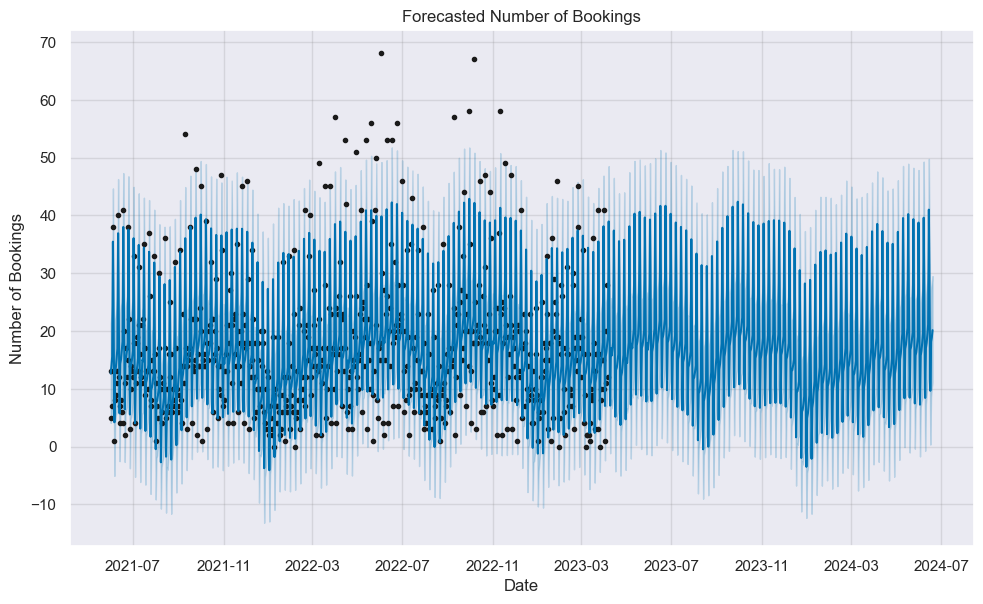

In [281]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.title('Forecasted Number of Bookings')

plt.show()

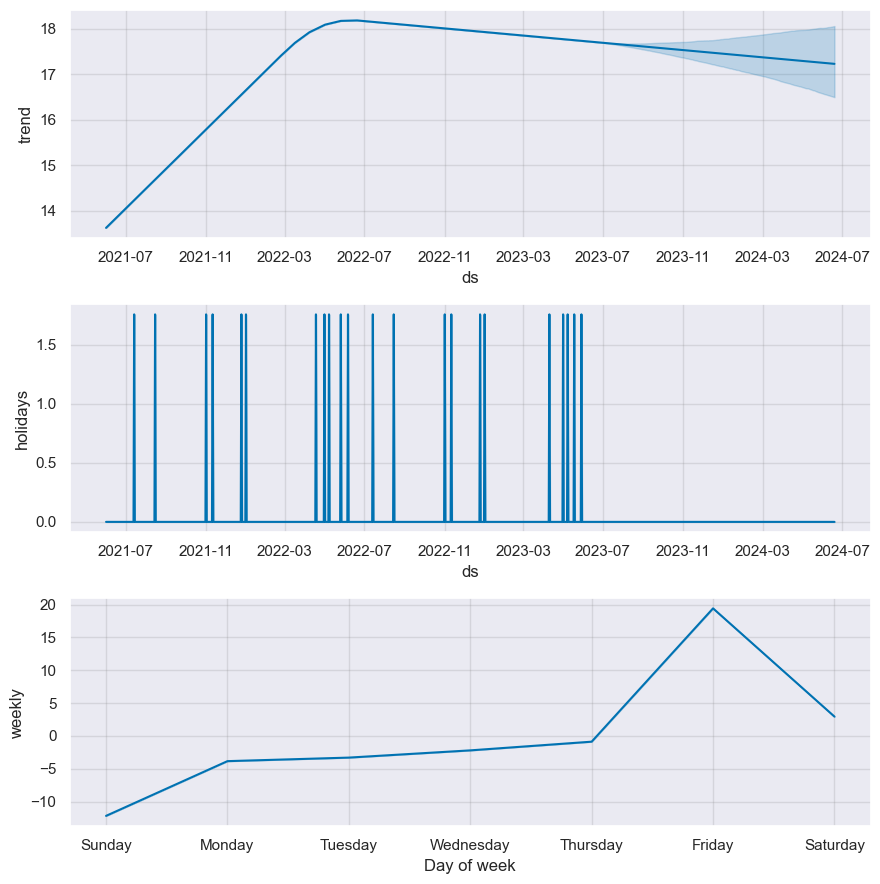

In [282]:
# Explain seasonality
fig2 = model.plot_components(forecast)